In [1]:
from pathlib import Path
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import epiweeks
import us

In [2]:
from data import *
from run import *
from hosps import HospModel, load_data as load_hosps_data
from death import DeathModel, load_data as load_death_data
from case import CaseModel, load_data as load_cases_data

In [20]:
data_type = 'hosps'
Models = dict(
    cases=CaseModel,
    death=DeathModel,
    hosps=HospModel,
)

In [23]:
start_date = '2020-04-15'
cond_size = 14
pred_size = 7
test_size = 7
n_rolls = 5 if data_type=='hosps' else 4
d_hidden = 32
case_window = 3
n_epochs = 1200 if data_type=='cases' else (600 if data_type == 'death' else 400)
lr = 1e-3
share_params = False
full_attention = False
symmetric = False
add_autoreg = False
cum_value = data_type in ['cases', 'death']
quantiles = (
    (0.025, 0.1, 0.25, 0.5)
    if data_type=='cases' else
    (0.01, 0.025) + tuple([0.05*i for i in range(1,11)])
)
var_penalty=1.0
device = 1

model_path = Path(f'dumps/submission/{data_type}')
model_path.mkdir(parents=True, exist_ok=True)

In [24]:
today = pd.to_datetime(datetime.today())
end_date = f"{today - pd.Timedelta((today.weekday()-6)%7, unit='d'):%Y-%m-%d}"
kwargs = dict(
    start_date=start_date,
    end_date=end_date,
    device=device,
    test_size=test_size,
)
if data_type in ['hosps', 'death']:
    kwargs['case_window'] = case_window
train_data, valid_data = eval(f"load_{data_type}_data")(**kwargs)

In [25]:
if data_type == 'cases':
    past = load_cdc_truth(
        death=False,
        cumulative=False,
        start_date=f"{pd.to_datetime(end_date)-pd.Timedelta(6*7-1, unit='d'):%Y-%m-%d}",
        end_date=end_date,
    ).resample('W-SAT').sum()
elif data_type == 'death':
    past = load_cdc_truth(
        death=True,
        cumulative=False,
        start_date=f"{pd.to_datetime(end_date)-pd.Timedelta(6*7-1, unit='d'):%Y-%m-%d}",
        end_date=end_date,
    ).resample('W-SAT').sum()
else:
    past = load_hospitalized_data(
        increase=True, cumulative=False,
        start_date=f"{pd.to_datetime(end_date)-pd.Timedelta(6*7, unit='d'):%Y-%m-%d}", 
        end_date=end_date
    )
    #past = hosps.diff(1).iloc[1:]

In [26]:
seed = 42
pt.manual_seed(seed)
n_location = 51 if data_type in ['cases', 'death'] else 32
Model = Models[data_type]
model = Model(
    cond_size, pred_size, n_rolls, d_hidden,
    n_location, case_window, quantiles,
    d_feats=train_data.get('query_time_feats', pt.Tensor(0,0,0)).size(2),
    share_params=share_params,
    full_attention=full_attention,
    var_penalty=var_penalty,
).cuda(device)
optimizer = Adam(model.parameters(), lr=lr)

In [27]:
train(
    train_data,
    valid_data,
    model,
    optimizer,
    model_path=model_path.joinpath(f"{data_type}-{seed}-{end_date}.pkl"),
    n_epochs=n_epochs,
    test_size=test_size,
    patience=100,
)

100%|██████████| 400/400 [00:33<00:00, 11.93epoch/s, train_loss=31.4, valid_loss=381]


In [28]:
pr = inference(train_data, model, model_path.joinpath(f"{data_type}-{seed}-{datetime.today():%Y-%m-%d}.pkl"))

In [29]:
if data_type in ['cases', 'death']:
    index = pd.date_range(
        start=pd.to_datetime(end_date)+pd.Timedelta(6, unit='d'),
        periods=n_rolls, 
        freq='W-SAT',
    )
    mid_pr = pd.DataFrame(
        data=pr[:,0,len(quantiles)].cpu().numpy().astype(np.int64).T,
        index=index,
        columns=past.columns,
    )
else:
    mid_pr = pd.DataFrame(
        data=pr[:,0,len(quantiles)].cpu().numpy().astype(np.int64).T,
        index=pd.date_range(start=end_date, periods=pred_size*n_rolls, freq='d'),
        columns=past.columns,
    )

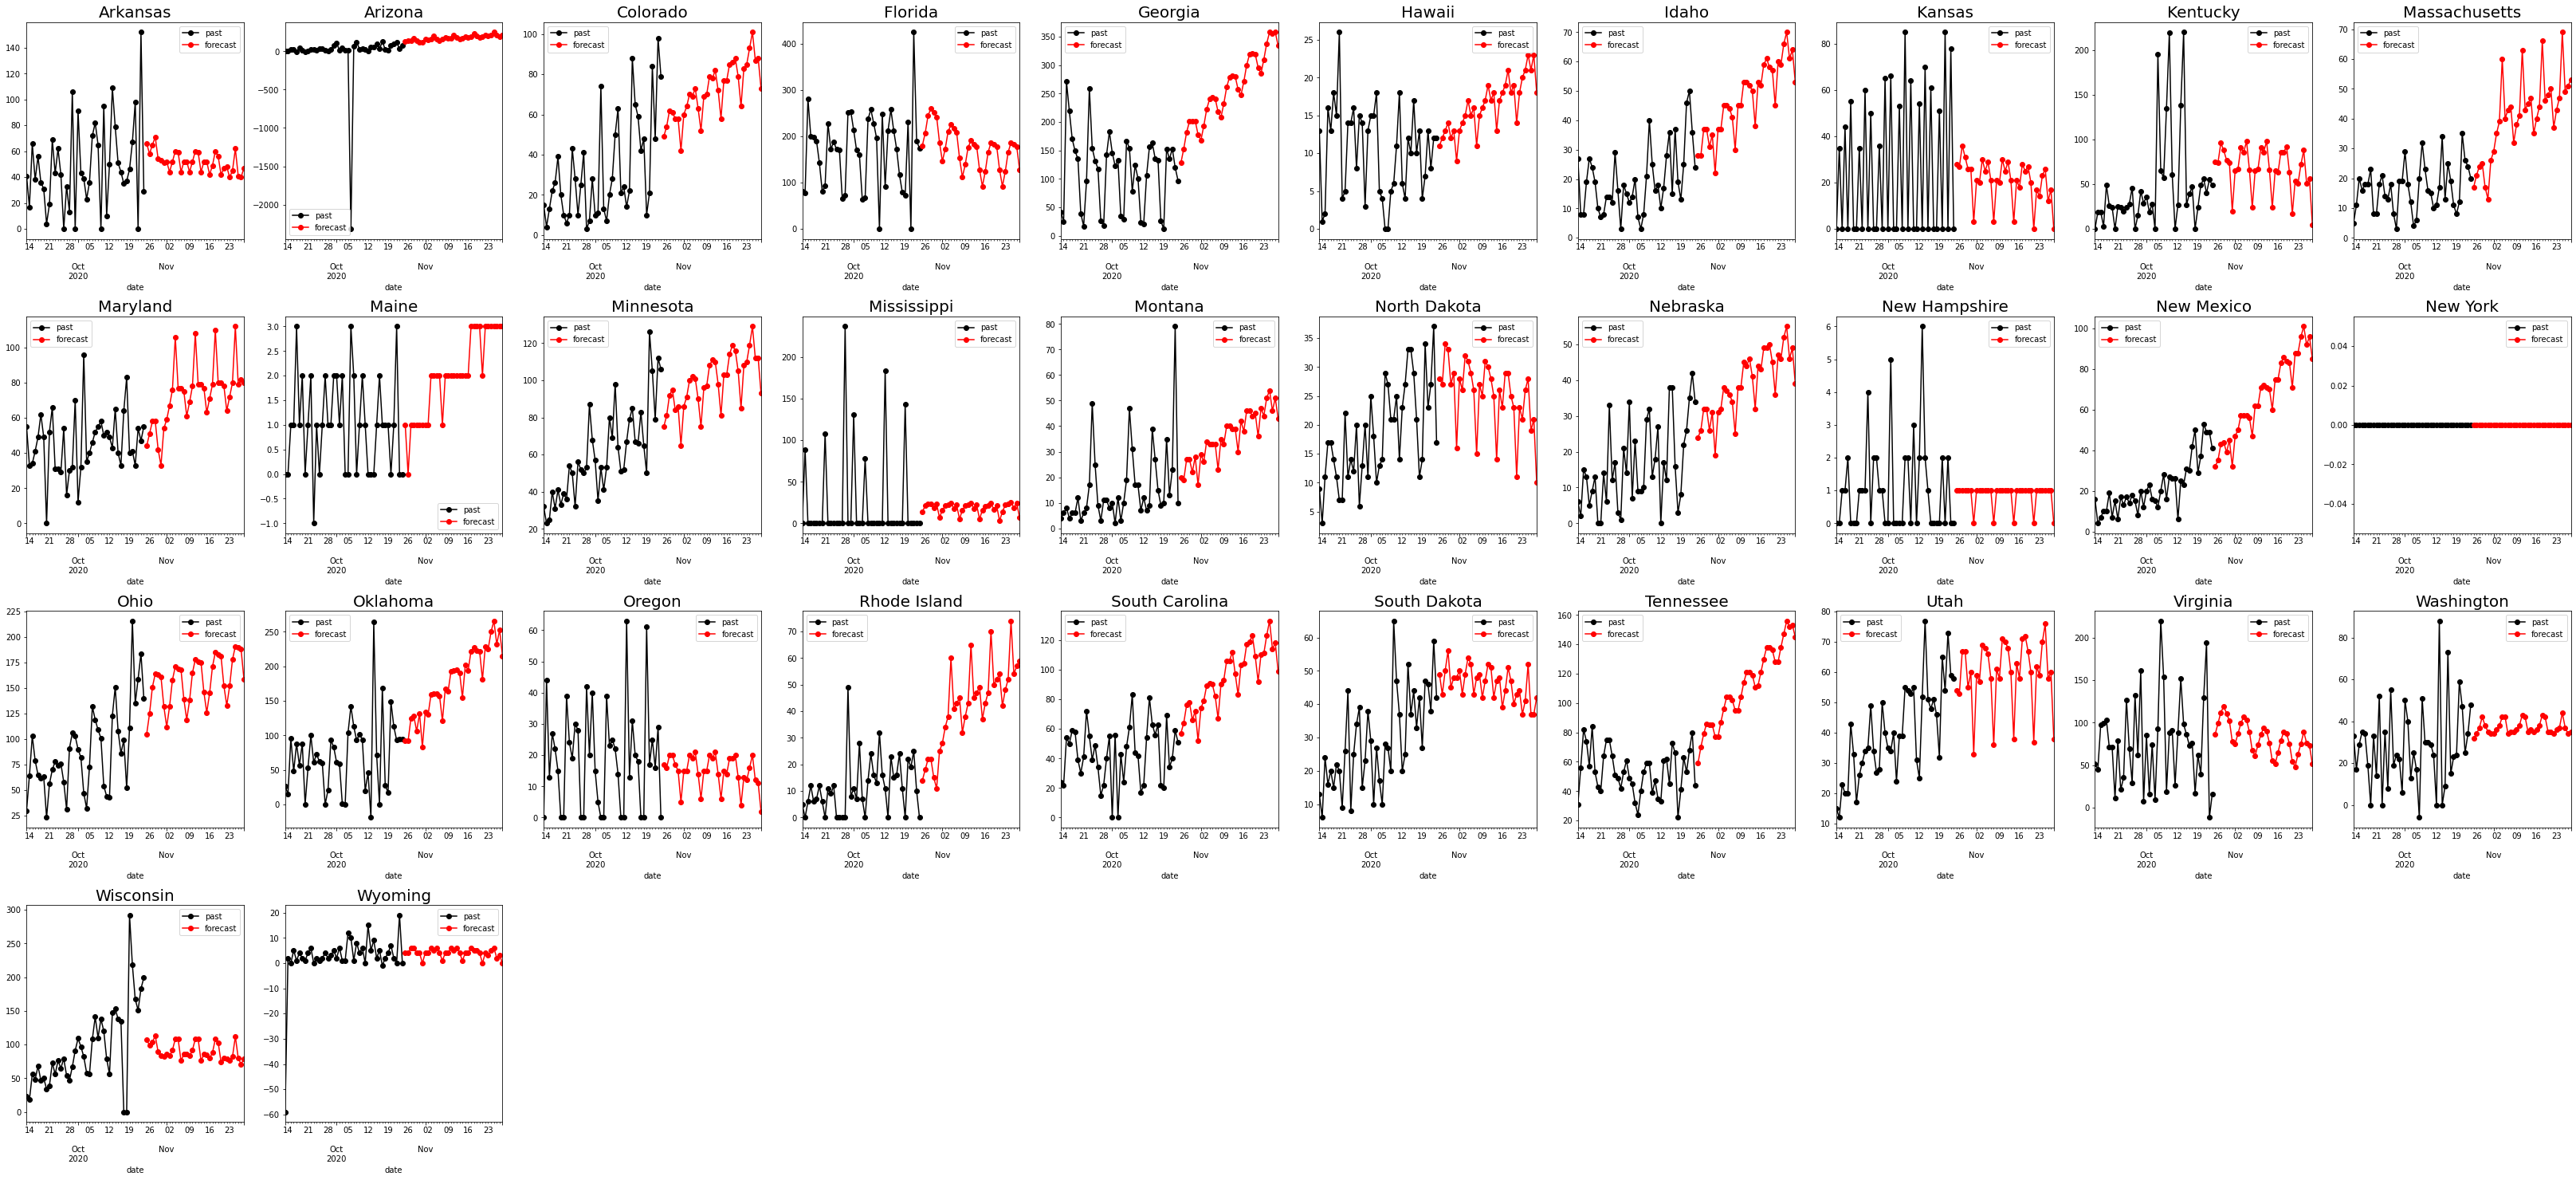

In [30]:
cumulative = True
fig = plt.figure(figsize=(45,30))
for i, s in enumerate(past.columns, 1):
    ax = fig.add_subplot(6,10,i)
    ax = past.plot(y=s, ax=ax, style='ko-', label='past')
    ax = mid_pr.plot(y=s, ax=ax, style='ro-', label='forecast')
    ax.set_title(s, fontsize=20)
fig.tight_layout()

In [33]:
def generate_dataframe(pr, states, cumulative):
    sub = defaultdict(list)
    if data_type in ['cases', 'hosps']:
        cumulative = False
    preds = pr[:,0].cpu().numpy()
    if data_type == 'cases':
        target = "{} wk ahead inc case"
    elif data_type == 'hosps':
        target = "{} day ahead inc hosp"
    else:
        if cumulative:
            target = "{} wk ahead cum death"
            base = load_cdc_truth(
                death=True, cumulative=True,
                start_date=f"{pd.to_datetime(end_date)-pd.Timedelta(1, unit='d'):%Y-%m-%d}",
                end_date=end_date,
            ).values.T
            preds = np.cumsum(np.concatenate([np.tile(np.expand_dims(base, axis=1), [1,len(model.quantiles),1]), preds], axis=-1), axis=-1)[...,1:]
        else:
            target = "{} wk ahead inc death"
    for i, state in enumerate(states):
        days = range(4) if data_type in ['cases', 'death'] else range(1,29)
        fc = preds[i]
        fc = np.sort(fc, axis=0)
        for d in days:
            sub['forecast_date'].append(f"{today:%Y-%m-%d}")
            sub['target'].append(target.format(d))
            sub['target_end_date'].append(f"{mid_pr.index[d]:%Y-%m-%d}")
            sub['location'].append(getattr(us.states, state2abbr[state]).fips)
            sub['type'].append('point')
            sub['quantile'].append('NA')
            sub['value'].append(fc[len(quantiles)-1,d])
            for j,q in enumerate(model.quantiles):
                sub['forecast_date'].append(f"{today:%Y-%m-%d}")
                sub['target'].append(target.format(d))
                sub['target_end_date'].append(f"{mid_pr.index[d]:%Y-%m-%d}")
                sub['location'].append(getattr(us.states, state2abbr[state]).fips)
                sub['type'].append('quantile')
                sub['quantile'].append(f"{q:.3f}".rstrip('0'))
                sub['value'].append(fc[j,d])
    return pd.DataFrame(sub)

In [34]:
cumulative=False
sub = generate_dataframe(pr, past.columns.to_list(), cumulative)
sub.to_csv(model_path.joinpath(f"{end_date}-{'cum' if cumulative else 'inc'}.csv"))

In [35]:
dumps = Path('dumps/submission')

In [37]:
pd.concat([
    pd.read_csv(dumps.joinpath(f'death/{end_date}-cum.csv'), index_col=0, dtype=str),
    pd.read_csv(dumps.joinpath(f'death/{end_date}-inc.csv'), index_col=0, dtype=str),
    pd.read_csv(dumps.joinpath(f'hosps/{end_date}-inc.csv'), index_col=0, dtype=str),
    pd.read_csv(dumps.joinpath(f'cases/{end_date}-inc.csv'), index_col=0, dtype=str),
], axis=0).fillna('NA').to_csv(f'dumps/submission/{today:%Y-%m-%d}-UCSB-ACTS.csv', index=False)